In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %%
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from copy import deepcopy
from collections import Counter
from copy import deepcopy as copy
from eBLEU import MultiBLEUMultiply
from eBLEU import CUDA_wrapper
from eBLEU_from_paper import bleu as paper_bleu
from eBLEU_from_paper import O2
from IPython.display import set_matplotlib_formats

In [3]:
def one_hots(zeros, ix):
    for i in range(zeros.size()[0]):
        zeros[i, ix[i]] = 1
    return zeros

In [4]:
def training(t, r_hot, r, f, n):
    res = []
    bleus = []
    norms = []
    probs = []
    lr = 100
    opt = torch.optim.Adam([t], lr=1)
    for i in range(100):
        b2 = paper_bleu(t, r_hot, r, f, 1, n)
        res.append(b2.data[0])
        probs.append(f(t).data.cpu().numpy())
        (-b2).backward()
        opt.step()
        norms.append(t.grad.data.norm())
        hard_t = Variable(CUDA_wrapper(one_hots(torch.zeros(list(t.size())), torch.max(t, dim=1)[1].data)))
        bleus.append(-mbleu(torch.unsqueeze(r_hot, 0), torch.unsqueeze(hard_t, 0), [10], [10])[0].data[0])
    return res, bleus, probs

In [5]:
def estimate_expectation(probs, mbleu, length, n_exp = 100):
    bs = []
    bst = []
    for p in probs:
        bs = []
        for i in range(n_exp):
            samples = []
            for l in range(length):
                samples.append(np.random.multinomial(1, p[l]/ np.sum(p[l]) - 1E-7))
            text = np.array(samples).astype(np.float32)
            bs.append(-mbleu(torch.unsqueeze(r_hot, 0),
                            torch.unsqueeze(Variable(CUDA_wrapper(torch.from_numpy(text))), 0),
                            [10], [10])[0].data[0])
        bst.append(np.array(bs).mean())
    return bst

In [6]:
def plot_results(bleus, bst, res):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}
    set_matplotlib_formats('png')
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.plot(bleus, '-', linewidth=2, label='Exact BLEU with argmax')
    plt.plot(bst, 'X', linewidth=6, label='Expected BLEU')
    plt.plot(res, '--', linewidth=2, label='Lower Bound for Expected BLEU')
    plt.ylabel('BLEU score')
    plt.xlabel('training steps')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


In [7]:
# def get_bleus_lb(precisions, n):
#     res = []
#     for i in range(len(precisions[0])):
# #         b = reduce(lambda x, y: x * y, [precisions[j][i] for j in range(n)])
#         p_log_sum = np.sum((1./n) * np.log(np.array([precisions[j][i] for j in range(n)])))
#         geo_mean = np.exp(p_log_sum)
#         res.append(geo_mean)
#     return res

1.0


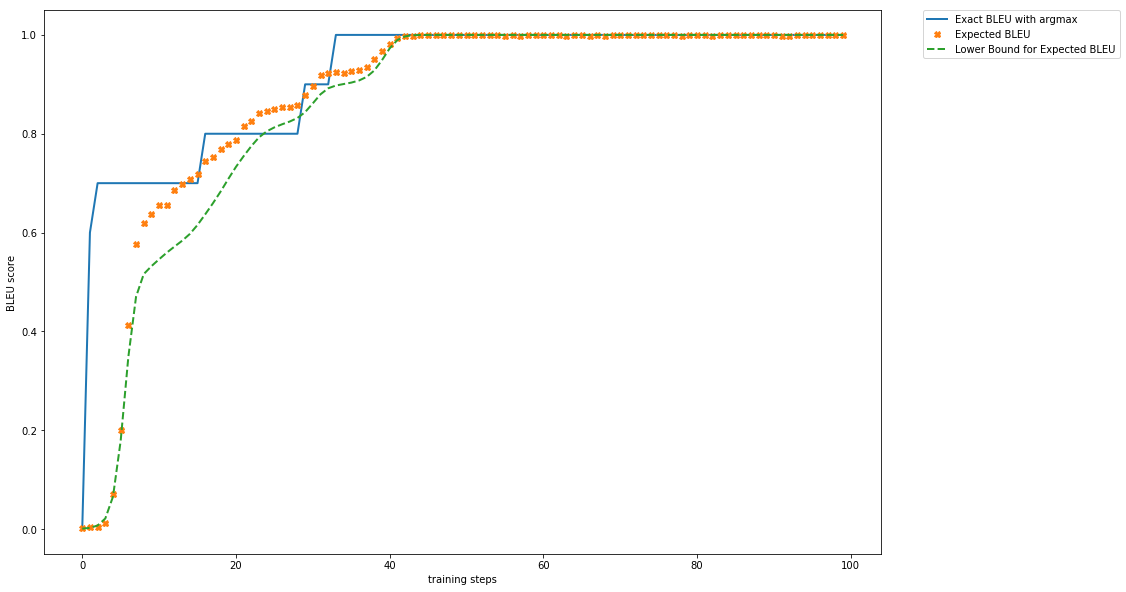

0.7071067690849304


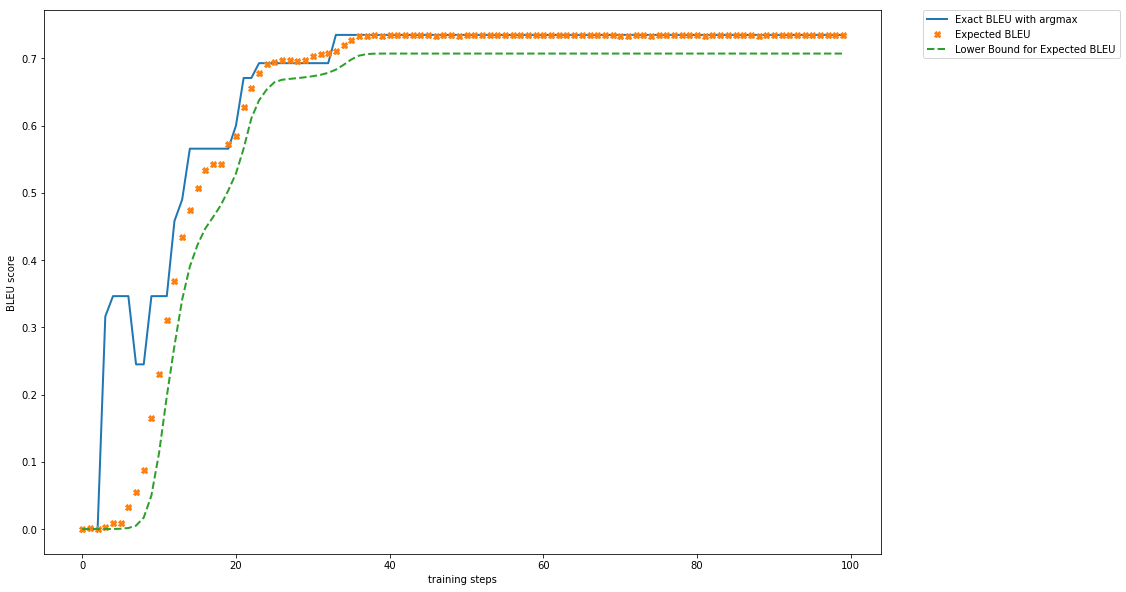

In [8]:
precisions = []
all_bleus = []
all_bst = []
for n in range(1, 3):
    vocab_size = int(1E4)
    length = 10
    f = nn.Softmax()
    words = np.random.choice(vocab_size, size=length, replace = True)
    t = Variable(CUDA_wrapper(torch.randn((length, vocab_size))), requires_grad=True)
    r = torch.LongTensor(words)
    r_hot = Variable(CUDA_wrapper(one_hots(torch.zeros((length, vocab_size)), words)))
    r = Variable(CUDA_wrapper(r), requires_grad=False)
    mbleu = MultiBLEUMultiply(max_order=n, softmax_temperature=0.00001)
    res, bleus, probs = training(t, r_hot, r, f, n)
    bst = estimate_expectation(probs, mbleu, length)
    precisions.append(res)
    all_bleus.append(bleus)
    all_bst.append(bst)
    print(res[-1])
    plot_results(bleus, bst, res)
#     cur_bleu_lb = get_bleus_lb(precisions, n)
#     plot_results(bleus, bst, get_bleus_lb(precisions, n))

In [9]:
r_hot[:,1]

Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 10]